In [ ]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import transform_classes

#from roi import RoiLearn
#from roi_dataset import RoiDataset
from autoencoder import Autoencoder
from preprocessor import Preprocessor
from PIL import Image
from autoencoder_dataset import AEDataset

import preprocess_img

In [ ]:
# if we don't have the .csv file
preprocess_img.write_all_rectangle2file('O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_1\\')

In [ ]:
print(torch.device('cuda'))

In [ ]:
csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'

compose3 = Compose([transform_classes.StandardScale2(),transform_classes.ToTensor()])

ds2 = AEDataset(csv_file, compose3, sample_size = 1000)
roi = RoiLearn()
roi.build_ae()

crit = torch.nn.MSELoss(size_average = True)
opt = torch.optim.Adam(roi.autoencoder.parameters(), weight_decay = 0.0001 )

dataset_loader = torch.utils.data.DataLoader(ds2,batch_size=128, num_workers=0)

roi.learn_ae(dataset_loader, optimizer = opt, criterion = crit,  ep = 1000)
#roi.ae_weights2model_feature_set()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
#roi.autoencoder()
idx = 2
_,decoded = roi.autoencoder(ds2.__getitem__(idx)['image'])
image = Image.fromarray( np.reshape(decoded.detach().numpy(), (11,11)), mode='L')
image2 = Image.fromarray( np.reshape(roi.normalize_range(ds2.__getitem__(idx)['image']).numpy(), (11,11)), mode='L')
plt.imshow(np.reshape(decoded.detach().numpy(), (11,11)), cmap=plt.cm.bone) 

In [ ]:
plt.imshow(np.reshape(roi.normalize_range(ds2.__getitem__(idx)['image']).numpy(), (11,11)), cmap=plt.cm.bone) 

In [257]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_wrangling.dicom_reader import DCMreader
import pydicom as dicom

class RoiDataset(Dataset):
    """Roi dataset."""

    def __init__(self, csv_file, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with contour data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        'height is  (y length) width is  (x length)'
        self.contour_data = pd.read_csv(csv_file,sep=';', names=('path','slice', 'frame', 'xmin', 'ymin', 'height','width' ))
        self.contour_data = self.contour_data.sample(8)
        self.dcm_images = {}
        for path in self.contour_data['path']:
            temp_ds = dicom.dcmread(path)
            self.dcm_images[str(path)] = temp_ds.pixel_array
            
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.contour_data)
    
    def __getitem__(self, idx):
        if isinstance(idx,torch.Tensor):
            idx = idx.item()
        cont = self.contour_data.iloc[idx]
        sl = int(cont['slice'])
        fr = int(cont['frame'])
        
        mask = np.zeros((224,224))
        mask[ int(cont['ymin']): int(cont['ymin']) + int(cont['height']),int(cont['xmin']): int(cont['xmin']) + int(cont['width'])] = 1
        image = self.dcm_images[str(cont['path'])]
        
        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample['image'] = self.transform(sample['image']).cuda()
        if self.target_transform:
            sample['mask'] = self.target_transform(sample['mask']).cuda()

        return sample
        

In [258]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn
from autoencoder import Autoencoder
from roinn import RoiNN


class RoiLearn:
    def __init__(self):
        torch.manual_seed(23)
        '''self.conv1 = nn.Conv2d(1,100, (11,11))
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AvgPool2d(6)
        self.flatten = Flatten()
        self.full = nn.Linear(8100,1024)'''
        #self.encoder = nn.Linear(121,100)
        #self.decoder = nn.Linear(100,121)
          
    # Autoencoder architecture
    def build_ae(self):
        self.autoencoder = Autoencoder(121,100).to('cuda')
        self.autoencoder = self.autoencoder.double()
        
    def save_ae_weights(self,path):
        torch.save(self.autoencoder.state_dict(), path)

    def load_ae_weights(self,path):
        self.build_ae()
        self.autoencoder.load_state_dict(torch.load(path))

    def build_model(self):
        self.model = RoiNN().to('cuda')
        self.model = self.model.double()
        
    def save_model_weights(self,path):
        torch.save(self.model.state_dict(), path)

    def load_model_weights(self,path):
        self.build_ae()
        self.model.load_state_dict(torch.load(path))
        
    # Autoencoder W2 and b2 to the original model conv1 layer features and biases.
    # From the parameters list - index 0 is the weights
    #                          - index 1 is the biases
    def ae_weights2model_feature_set(self):
        
        w2 = self.autoencoder.encoder.weight.cpu().detach().numpy()
        b2 = self.autoencoder.encoder.bias.cpu().detach().numpy()
        
        # weights shape here (100,121)
        w2 = np.expand_dims(w2.reshape((100,11,11)), axis = 1)
        # weights shape (100,1,11,11)


        self.model.conv1.weight = torch.nn.Parameter(torch.from_numpy(w2))
        self.model.conv1.bias = torch.nn.Parameter(torch.from_numpy(b2))
        self.model.conv1 = self.model.conv1.cuda()
        self.model.conv1.weight.requires_grad=False
        self.model.conv1.bias.requires_grad=False
        
    
    def normalize_range(self, vector):
        min_v = torch.min(vector)        
        range_v = torch.max(vector) - min_v
        
        if range_v > 0:
            normalised = (vector - min_v) / range_v
        else:
            normalised = torch.zeros(vector.size())
        return normalised

    ''' Learn the autoencoder features for the original convolution weights.
        Params:
            dataset_loader - the prepared dataset inside a configured pytorch dataloader
            optimizer - for the backpropagation
            criterion - method for the half part of the loss function
            ep - epochs
            lr - learning rate
            BETA - weightening the sparsity part of the loss function
            RHO - the sample distribution for comparing the average activation (sparse part of the loss function too.)
    '''     
    def learn_ae(self, dataset_loader, optimizer,criterion, ep = 1, lr = 0.01, BETA = 3, RHO = 0.1):
        
        rho = torch.tensor([RHO for _ in range(self.autoencoder.n_hidden)]).double()
        crit2 = nn.KLDivLoss(size_average=False)
        for epoch in range(ep):
            for i_batch, sample_batched in enumerate(dataset_loader):
    
                # Forward
                encoded, decoded = self.autoencoder(sample_batched['image'])
                # Loss
                # first loss is the loss what the user can choose
                first_loss = criterion(self.normalize_range(sample_batched['image']), decoded)                
                # the second loss member is the penalty loss, this helps the higher feature learning
                sparsity_loss = crit2( F.log_softmax(torch.mean(encoded, dim = 0)) , rho)        
                loss = first_loss + BETA*sparsity_loss
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print('epoch: ', epoch,' loss: ', loss.item())
                 

    def learn_roi(self, dataset_loader, optimizer,criterion, ep = 1):
        for epoch in range(ep):
            for i_batch, sample_batched in enumerate(dataset_loader):
                # Forward
                out = self.model(sample_batched['image'])
                # Loss
                loss = criterion(sample_batched['mask'], out)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print('epoch: ', epoch,' loss: ', loss.item())


In [282]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import Compose
import transform_classes
import torch as th

th.cuda.set_device(0)

csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'
compose1 = Compose([transform_classes.ReScale64(),transform_classes.StandardScale(),transform_classes.ToTensor()])
compose2 = Compose([transform_classes.ReScale32(),transform_classes.ToTensor()])
ds = RoiDataset(csv_file, compose1, compose2)

roi = RoiLearn()
roi.build_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(roi.model.parameters(),weight_decay = 0.0001)

dataset_loader = torch.utils.data.DataLoader(ds,batch_size=8, shuffle=False,num_workers=0)
ae_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_w.pth'
roi.load_ae_weights(ae_weights_folder)
roi.ae_weights2model_feature_set()

In [283]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
roi.learn_roi(dataset_loader, optimizer, criterion, ep = 1000)

epoch:  0  loss:  403.2180381875637
epoch:  1  loss:  403.09507719106307
epoch:  2  loss:  402.9540108103622
epoch:  3  loss:  402.79316308772223
epoch:  4  loss:  402.61060031354145
epoch:  5  loss:  402.40434218595885
epoch:  6  loss:  402.17246920158163
epoch:  7  loss:  401.9132294972831
epoch:  8  loss:  401.6251619256397
epoch:  9  loss:  401.30722985202436
epoch:  10  loss:  400.95895578437813
epoch:  11  loss:  400.5805517942664
epoch:  12  loss:  400.1730337886746
epoch:  13  loss:  399.73829477245505
epoch:  14  loss:  399.2791233006998
epoch:  15  loss:  398.79916471530004
epoch:  16  loss:  398.30281407429806
epoch:  17  loss:  397.79502799203397
epoch:  18  loss:  397.2810653635605
epoch:  19  loss:  396.7661931489461
epoch:  20  loss:  396.25540394424115
epoch:  21  loss:  395.75318990454025
epoch:  22  loss:  395.2634005228973
epoch:  23  loss:  394.7891841631019
epoch:  24  loss:  394.3329973002518
epoch:  25  loss:  393.89666143298354
epoch:  26  loss:  393.48144582014

epoch:  216  loss:  388.4166879884982
epoch:  217  loss:  388.4160994730738
epoch:  218  loss:  388.41551698665893
epoch:  219  loss:  388.4149404238661
epoch:  220  loss:  388.4143696813048
epoch:  221  loss:  388.4138046578391
epoch:  222  loss:  388.41324525480866
epoch:  223  loss:  388.4126913762088
epoch:  224  loss:  388.412142928832
epoch:  225  loss:  388.41159982237093
epoch:  226  loss:  388.4110619694832
epoch:  227  loss:  388.4105292858208
epoch:  228  loss:  388.41000169002683
epoch:  229  loss:  388.40947910370136
epoch:  230  loss:  388.4089614513411
epoch:  231  loss:  388.4084486602553
epoch:  232  loss:  388.40794066046163
epoch:  233  loss:  388.4074373845662
epoch:  234  loss:  388.40693876763135
epoch:  235  loss:  388.4064447470342
epoch:  236  loss:  388.4059552623182
epoch:  237  loss:  388.40547025504424
epoch:  238  loss:  388.40498966863953
epoch:  239  loss:  388.40451344824925
epoch:  240  loss:  388.4040415405932
epoch:  241  loss:  388.40357389382706
ep

epoch:  430  loss:  388.3519936659817
epoch:  431  loss:  388.3517679267611
epoch:  432  loss:  388.3515431281527
epoch:  433  loss:  388.3513193557157
epoch:  434  loss:  388.351096692683
epoch:  435  loss:  388.3508752194062
epoch:  436  loss:  388.35065501283856
epoch:  437  loss:  388.3504361460676
epoch:  438  loss:  388.35021868790125
epoch:  439  loss:  388.3500027025168
epoch:  440  loss:  388.34978824917255
epoch:  441  loss:  388.3495753819861
epoch:  442  loss:  388.34936414977585
epoch:  443  loss:  388.34915459596374
epoch:  444  loss:  388.3489467585327
epoch:  445  loss:  388.34874067003284
epoch:  446  loss:  388.3485363576276
epoch:  447  loss:  388.3483338431744
epoch:  448  loss:  388.34813314332877
epoch:  449  loss:  388.3479342696687
epoch:  450  loss:  388.34773722883114
epoch:  451  loss:  388.34754202265844
epoch:  452  loss:  388.3473486483515
epoch:  453  loss:  388.34715709863025
epoch:  454  loss:  388.3469673619012
epoch:  455  loss:  388.3467794224327
epo

epoch:  644  loss:  388.32578403379455
epoch:  645  loss:  388.3257279835177
epoch:  646  loss:  388.32567228180676
epoch:  647  loss:  388.3256169243837
epoch:  648  loss:  388.3255619069333
epoch:  649  loss:  388.32550722510484
epoch:  650  loss:  388.32545287451387
epoch:  651  loss:  388.32539885074345
epoch:  652  loss:  388.3253451493474
epoch:  653  loss:  388.32529176585234
epoch:  654  loss:  388.32523869576016
epoch:  655  loss:  388.32518593455154
epoch:  656  loss:  388.32513347768963
epoch:  657  loss:  388.3250813206234
epoch:  658  loss:  388.3250294587919
epoch:  659  loss:  388.32497788762913
epoch:  660  loss:  388.3249266025696
epoch:  661  loss:  388.32487559905246
epoch:  662  loss:  388.3248248725286
epoch:  663  loss:  388.32477441846544
epoch:  664  loss:  388.3247242323546
epoch:  665  loss:  388.3246743097169
epoch:  666  loss:  388.3246246461105
epoch:  667  loss:  388.3245752371361
epoch:  668  loss:  388.32452607844505
epoch:  669  loss:  388.3244771657449

epoch:  858  loss:  388.3177051345694
epoch:  859  loss:  388.3176778581829
epoch:  860  loss:  388.317650644005
epoch:  861  loss:  388.3176234917477
epoch:  862  loss:  388.31759640112506
epoch:  863  loss:  388.31756937185304
epoch:  864  loss:  388.31754240364927
epoch:  865  loss:  388.31751549623385
epoch:  866  loss:  388.3174886493279
epoch:  867  loss:  388.3174618626555
epoch:  868  loss:  388.31743513594154
epoch:  869  loss:  388.3174084689135
epoch:  870  loss:  388.3173818613004
epoch:  871  loss:  388.317355312833
epoch:  872  loss:  388.31732882324394
epoch:  873  loss:  388.3173023922676
epoch:  874  loss:  388.31727601964025
epoch:  875  loss:  388.31724970509975
epoch:  876  loss:  388.31722344838573
epoch:  877  loss:  388.3171972492397
epoch:  878  loss:  388.31717110740453
epoch:  879  loss:  388.3171450226251
epoch:  880  loss:  388.31711899464784
epoch:  881  loss:  388.3170930232209
epoch:  882  loss:  388.31706710809385
epoch:  883  loss:  388.31704124901836
e

KeyboardInterrupt: 

In [241]:
roi.model.conv1.weight.requires_grad=True
roi.model.conv1.bias.requires_grad=True

[0.062602]


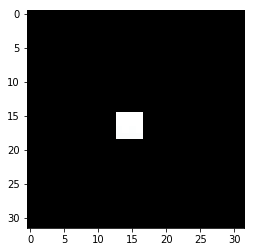

In [284]:
from PIL import Image
import matplotlib.pyplot as plt
#roi.autoencoder()

idx = 0
out = roi.model(torch.from_numpy(np.expand_dims(ds.__getitem__(idx)['image'], axis = 0)).cuda())
#print(np.amax(out.detach().numpy() ))
print(np.amax(out.cpu().detach().numpy(),axis=1))
plt.imshow(np.reshape(out.cpu().detach().numpy(), (32,32)), cmap=plt.cm.bone) 

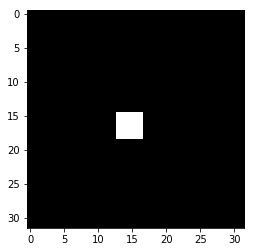

In [285]:
plt.imshow(np.reshape((ds.__getitem__(idx)['mask']).cpu().numpy(), (32,32)), cmap=plt.cm.bone)

In [247]:
torch.cuda.max_memory_allocated()

612979200